<a href="https://colab.research.google.com/github/odesay97/MachineLearing_Class/blob/main/8_2_%EA%B7%B8%EB%A6%BC_%EC%97%86%EC%9D%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 완전 연결 신경망 vs 합성곱 신경망
완전 연결 신경망에서는 입력 이미지를 밀집층에 연결하기 위해 일렬로 펼쳐야 했으나

합성곱 신경망에서는 2차원 이미지를 그대로 이용하므로 펼치지 않음

다만 입력 이미지는 항상 깊이(채널)이 있어야 하므로 채널 차원을 추가함

그림

In [54]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [55]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

# (input, target) (input, target)
(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

# (48000, 28, 26) -> (48000, 28, 28, 1)로 변경
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0

# input,input, target,target
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

## 합성곱 신경망 만들기

In [56]:
model = keras.Sequential()

첫번째 합성곱 층

그림

In [57]:
# input_shape는 얘가 input이 뭔지 모르니까 형식 알려주는 거임
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                              padding='same', input_shape=(28,28,1)))

model.add(keras.layers.MaxPooling2D(2))

두번쨰 합성곱 층 + 완전 연결 층

과대적합을 막기 위해 드롭아웃을 추가

그림

In [58]:
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu',
                              padding='same'))

model.add(keras.layers.MaxPooling2D(2))

In [59]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

In [60]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_3 (Flatten)         (None, 3136)              0         
                                                                 
 dense_6 (Dense)             (None, 100)              

### 모델 파라미터 수를 계산해보자

* 첫번쨰 합성곱 층은 (3,3,1) 크기의 32개의 필터를 가지고 있음 필터 마다 하나의 절편이 추가됨

  따라서 (3 * 3 * 1) * 32 + 32 = 320

* 두번째 합성곱 층은 (3,3,32) 크기의 64개의 필터를 가지고 있음 필터마다 하나의 절편이 추가됨

 따라서 (3 * 3 * 32) * 64 + 64 = 18496

* Flatten 층에서 (7,7,64) 크기의 특성 맵을 1차원 배열로 펼치면 7 * 7 * 64 = 3136 크기의 배열이 됨

 이를 100개의 뉴런과 완전히 연결해야하므로 은닉층의 모델 파라미터 개수는 3136 * 100 + 100 = 313700

* 마지막 출력 층은 100* 10 + 10 = 1010

* 각각의 연산에서 뒤에 더해지는 값 -> 각 뉴런이 찾아낸 절편의 개수

### 층의 구성을 그림으로 표현해보자

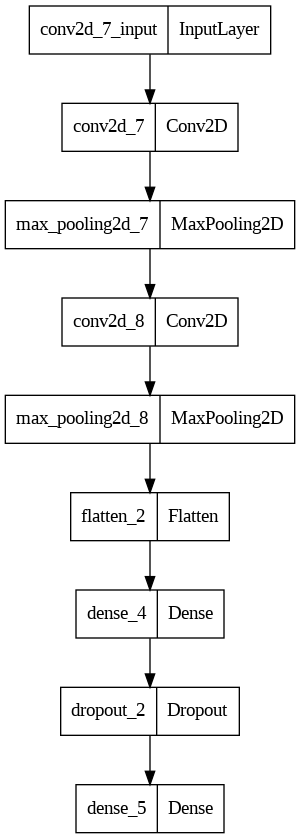

In [49]:
keras.utils.plot_model(model)

보면 맨 앞에 input layer 가 있다.

원래는 따로 넣어줘야되지만, keras는 자동으로 만들어준다.

입력과 출력의 크기도 같이 표현해보자

show_shpaes 매개변수를 True로 지정

to_file 매개변수에 파일 이름을 지정하면 출력된 이미지를 파일로저장함

기본값으로 to_file = 'model.png'로 지정되어 있음

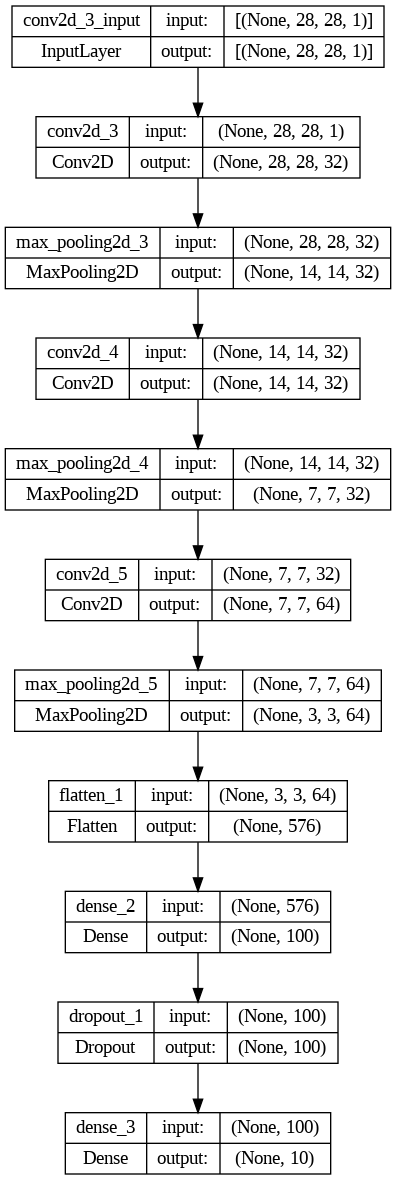

In [28]:
keras.utils.plot_model(model, show_shapes=True)

### 모델 컴파일과 훈련

In [61]:
# 그냥 저장하면 휘발되므로 내 구글드라이브에 영구저장하기 위해서 내 구글드라이브 마운트 (연결)
from google.colab import drive
drive.mount('/content/driver/')

ValueError: ignored

In [62]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

# 아래와 같이 저장하면 코랩 특성상 나중에 휘발됨
# checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5',save_best_only=True)

# 위에서 내 구글드라이브에 마운트 했다면 다음과 같이 내 구글드라이브에 저장할 수 있게됨
checkpoint_cb = keras.callbacks.ModelCheckpoint('/content/driver/MyDrive/best-cnn-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 9s 5ms/step - loss: 0.5091 - accuracy: 0.8178 - val_loss: 0.3178 - val_accuracy: 0.8823
Epoch 2/20
1500/1500 [==============================] - 10s 6ms/step - loss: 0.3382 - accuracy: 0.8775 - val_loss: 0.2747 - val_accuracy: 0.8964
Epoch 3/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2927 - accuracy: 0.8945 - val_loss: 0.2451 - val_accuracy: 0.9101
Epoch 4/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2583 - accuracy: 0.9064 - val_loss: 0.2343 - val_accuracy: 0.9131
Epoch 5/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2358 - accuracy: 0.9134 - val_loss: 0.2234 - val_accuracy: 0.9160
Epoch 6/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2151 - accuracy: 0.9211 - val_loss: 0.2149 - val_accuracy: 0.9220
Epoch 7/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1982 - accuracy: 0.9268 - val_loss: 0.2145 - val_accuracy

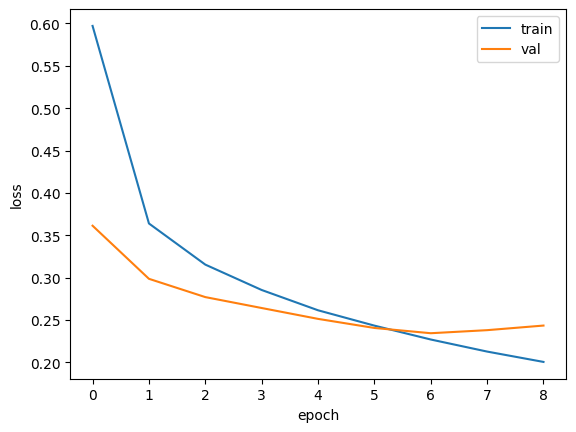

In [30]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

EarlyStopping 클래스에서 restore_best_weights 매개변수를 True로 지정했으므로 현재 model 객체에 최적의 모델 파라미터로 복원되어 있음

즉, ModelCheckpoint 콜백이 저장한 best-cnn-model.h5 파일을 다시 읽을 필요가 없음

In [32]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.2345 - accuracy: 0.9133


[0.2344934642314911, 0.9132500290870667]

### 첫번째 검증 데이터를 확인해보자

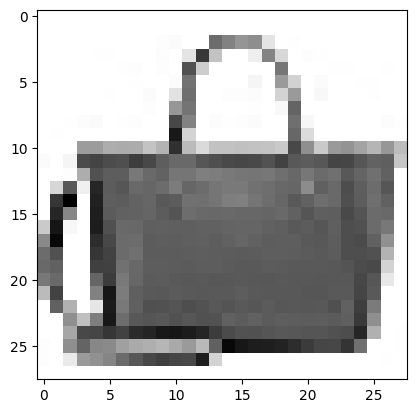

In [33]:
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

### 첫번쨰 검증 데이터를 예측해보자

In [34]:
preds = model.predict(val_scaled[0:1])
print(preds)

1/1 [==============================] - 0s 142ms/step
[[1.6070068e-14 6.0451661e-23 8.4856420e-20 6.3408350e-17 1.6552239e-16
  2.9735939e-15 5.4502166e-16 8.6644782e-14 1.0000000e+00 8.8760596e-14]]


### 슬라이싱한 이유

predict() 메소드에 데이터를 전달할 떄 val_scaled[0]가 아닌 val_scaled[0:1]와 같이 슬라이싱함

그 이유는 케라스의 fit(),predict(),evaluate() 메소드는 모두 입력의 첫번쨰 차원이 배치차원으로 생각하기 떄문임

따라서 샘플 하나를 전달할 떄는 (28,28,1)이 아니라 (1,28,28,1) 크기를 전달해야함

배열 슬라이싱은 인덱싱과 다르게 선택된 원소가 하나더라도 전체 차ㄴ원이 유지되어 (1,28,28,1) 크기로 만듬

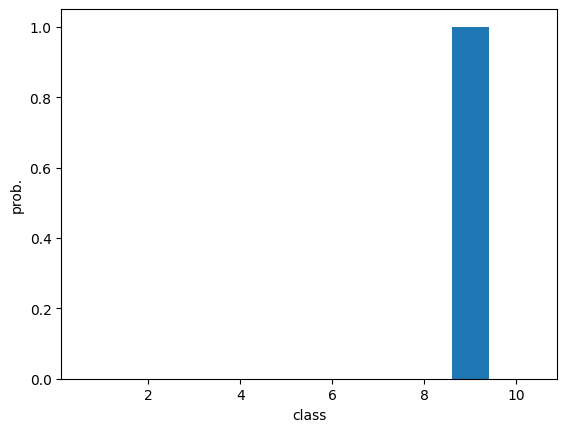

In [35]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [36]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트',
           '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

import numpy as np
print(classes[np.argmax(preds)])

가방


### 테스트 샘플에 대한 예측을 수행하자

In [37]:
# test의 형태와 입력의 형태가 동일해야하기 때문에 아래와 같이 3차원을 4차원 형태로 바꿈 + 정규화
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

model.evaluate(test_scaled, test_target)

313/313 [==============================] - 1s 3ms/step - loss: 0.2498 - accuracy: 0.9100


[0.24976128339767456, 0.9100000262260437]